In [16]:
from scipy.io import loadmat
from scipy.stats import gaussian_kde

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, StratifiedKFold

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
plt.style.use('seaborn-white')

In [4]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')
swr_event = loadmat('/Users/linggeli/Downloads/SuperChris-2-12-09_MS_RippleEvents.mat')

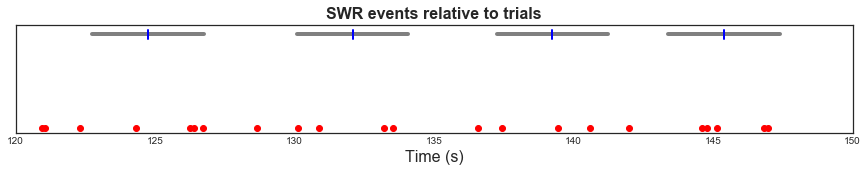

In [5]:
fig = plt.figure(figsize=(15, 2))
offset = 0.2
for i in range(5):
    actual_times = data_odor['trialTimeBins'][0][i][:, 0]
    start = actual_times[0]
    end = actual_times[-1]
    mid = (start + end) * 0.5
    plt.plot([start, end], [offset, offset], '-', linewidth=4, c='gray')
    plt.plot([mid, mid], [offset - 0.01, offset + 0.01], '-', linewidth=2, c='blue')
for j in range(200):
    start, end = swr_event['swrIndices'][j, :]
    plt.plot(start, 0, 'ro', lw=end-start, c='red')
plt.xlim(120, 150)
plt.xlabel('Time (s)', fontsize=16)
plt.yticks([], [])
plt.title('SWR events relative to trials', fontsize=16, fontweight='bold')
plt.show()

In [6]:
select = (data_odor['trialInfo'][:, 0] == 1) & (data_odor['trialInfo'][:, 1] == 1) & (data_odor['trialInfo'][:, 3] < 5)

In [7]:
trial_times = []  
trial_timebins = data_odor['trialTimeBins'][0, select]
n_trial = trial_timebins.shape[0]
for i in range(n_trial):
    actual_times = trial_timebins[i][:, 0]
    start = actual_times[0]
    end = actual_times[-1]
    trial_times.append([start, end])
trial_times = np.asarray(trial_times)

In [8]:
def find_swr_event(swr_start, swr_end, trial_times):
    n_trials = trial_times.shape[0]
    for i in range(n_trials):
        trial_start, trial_end = trial_times[i, :]
        if swr_start > trial_start and swr_end < trial_end:
            return i
    return -1

In [9]:
n_swr = swr_event['swrIndices'].shape[0]
swr_trial = np.zeros(n_swr)
for i in range(n_swr):
    swr_start, swr_end = swr_event['swrIndices'][i, :]
    swr_trial[i] = find_swr_event(swr_start, swr_end, trial_times)

In [10]:
def align_swr_times(swr_start, swr_end, trial_start, trial_end):
    mid = 0.5 * (trial_start + trial_end)
    return swr_start - mid, swr_end - mid

In [11]:
swr_times_aligned = []
for i, t in enumerate(swr_trial):
    if t != -1:
        swr_start, swr_end = swr_event['swrIndices'][i, :]
        trial_start, trial_end = trial_times[int(t), :]
        aligned_start, aligned_end = align_swr_times(swr_start, swr_end, trial_start, trial_end)
        swr_times_aligned.append([aligned_start, aligned_end])
swr_times_aligned = np.asarray(swr_times_aligned)

In [12]:
swr_trial_during = swr_trial[swr_trial != -1]

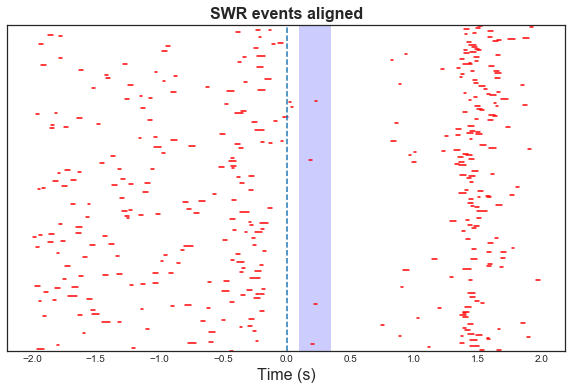

In [13]:
fig = plt.figure(figsize=(10, 6))
offset = 0.2
n = swr_times_aligned.shape[0]
for i in range(n):
    plt.plot(swr_times_aligned[i, :], [i * offset, i * offset], '-', color='red')
plt.xlabel('Time (s)', fontsize=16)
plt.yticks([], [])
plt.ylim(0, n * offset)
plt.title('SWR events aligned', fontsize=16, fontweight='bold')
plt.plot([0, 0], [0, n * offset], '--')
plt.fill([0.1, 0.1, 0.35, 0.35], [0, n * offset, n * offset, 0], 'b', alpha=0.2)
plt.show()

In [18]:
select_swr = swr_times_aligned[:, 0] > 1

In [19]:
swr_duration = swr_times_aligned[select_swr, 1] - swr_times_aligned[select_swr, 0]

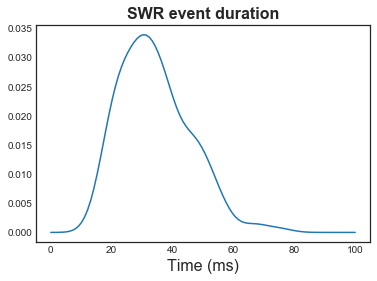

In [20]:
density = gaussian_kde(swr_duration * 1000)
xs = np.linspace(0, 100, 100)
density._compute_covariance()
plt.plot(xs, density(xs))
plt.xlabel('Time (ms)', fontsize=16)
plt.title('SWR event duration', fontsize=16, fontweight='bold')
plt.show()

In [21]:
all_spike_data = data_odor['unitEpoch'][select, 1:, :]
print(all_spike_data.shape)

(168, 4000, 46)


In [22]:
swr_index = 47
trial_index = swr_trial_during[select_swr][swr_index]
start_index, end_index = swr_times_aligned[swr_index] * 1000 + 2000
swr_data = all_spike_data[int(trial_index), int(start_index):int(end_index), :]

In [23]:
print(swr_data.shape)

(29, 46)


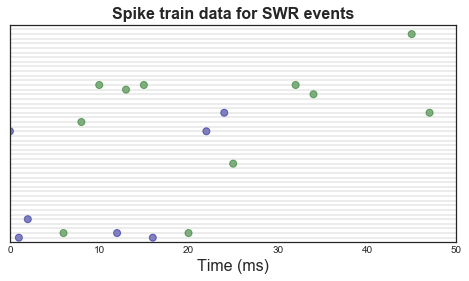

In [24]:
fig = plt.figure(figsize=(8, 4))

swr_index = 47
trial_index = swr_trial_during[select_swr][swr_index]
start_index, end_index = swr_times_aligned[swr_index] * 1000 + 2000
swr_data = all_spike_data[int(trial_index), int(start_index):int(end_index), :]
n_time, n_neuron = swr_data.shape
for i in range(n_neuron):
    plt.scatter(np.arange(n_time), np.ones(n_time) * i, s=swr_data[:, i] * 50, color='darkblue', alpha=0.5)

swr_index = 10
trial_index = swr_trial_during[select_swr][swr_index]
start_index, end_index = swr_times_aligned[swr_index] * 1000 + 2000
swr_data = all_spike_data[int(trial_index), int(start_index):int(end_index), :]
n_time, n_neuron = swr_data.shape
for i in range(n_neuron):
    plt.scatter(np.arange(n_time), np.ones(n_time) * i, s=swr_data[:, i] * 50, color='darkgreen', alpha=0.5)
    plt.plot([0, 60], [i, i], '-', c='gray', alpha=0.2)
    
plt.xlim(0, 50)
plt.ylim(-1, 46)
plt.xlabel('Time (ms)', fontsize=16)
plt.yticks([], [])
plt.title('Spike train data for SWR events', fontsize=16, fontweight='bold')
plt.show()

In [25]:
mean_feature = []
odor_target = []
prev_trial = -1
for i, t in enumerate(swr_trial_during[select_swr]):
    if prev_trial != t:
        start_index, end_index = swr_times_aligned[i] * 1000 + 2000
        swr_data = all_spike_data[int(t), int(start_index):int(end_index), :]
        mean_feature.append(np.mean(swr_data, axis=0))
        odor_target.append(data_odor['trialInfo'][select, 3][int(t)])
        prev_trial = t
mean_feature = np.asarray(mean_feature)
odor_target = np.asarray(odor_target)

In [26]:
print(mean_feature.shape)
print(odor_target.shape)

(123, 46)
(123,)


In [27]:
kf = StratifiedKFold(odor_target, n_folds=5)
overall_acc = []
y_total = np.zeros(odor_target.shape)
y_hat_total = np.zeros(odor_target.shape)
i = 0
for train_index, test_index in kf:
    X_train, X_test = mean_feature[train_index, :], mean_feature[test_index, :]
    y_train, y_test = odor_target[train_index], odor_target[test_index]
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=100)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    n_k = y_hat.shape[0]
    y_total[i:(i + n_k)] = y_test
    y_hat_total[i:(i + n_k)] = y_hat
    i += n_k
    accuracy = np.mean(y_hat == y_test)
    print('Current fold accuracy: {acc}'.format(acc=accuracy))
    overall_acc.append(accuracy)
print(np.mean(np.asarray(overall_acc)))

Current fold accuracy: 0.37037037037
Current fold accuracy: 0.541666666667
Current fold accuracy: 0.541666666667
Current fold accuracy: 0.333333333333
Current fold accuracy: 0.5
0.45740740740740743
